In [ ]:
import numpy as np
import tensorflow as tf
from random import random
from pathlib import Path
import ray
import json
from ray.rllib.policy.policy import Policy
from ray.rllib.algorithms.algorithm import Algorithm
from AmelioratingInventoryPOM import AmelioratingInventoryEnv as env
import ray.rllib.algorithms.apo as apo
from ray.tune.registry import register_env, register_trainable
from ray.rllib.utils.checkpoints import get_checkpoint_info
import scipy.stats as st
import os
from copy import deepcopy


c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#find order-up-to levels
#initialize environment
register_env("AmelioratingInventory", lambda config: env(config))

problem_ids = ["spirits_1102_n"]

for problem_id in problem_ids:   
    #problem_id = "spirits_1102"
    #set random seed
    
    path_json = Path(f"{os.getcwd()}/problem_configurations/{problem_id}/config.json") 
    with open(path_json, 'r') as f:
        JSON_config = json.load(f)

    price_mean = JSON_config["price_mean"]
    price_std = JSON_config["price_std"]
    price_truncation = JSON_config["price_truncation"]
    priceDistribution = st.truncnorm(loc=price_mean, scale=price_std, a=(-price_truncation/price_std), b=(price_truncation/price_std))

    demandDistributions = [st.norm(loc=JSON_config["demand_means"][i], scale=JSON_config["demand_covs"][i]*JSON_config["demand_means"][i]) for i in range(JSON_config["nProducts"])]
    salesPriceDistributions = [st.norm(loc=JSON_config["sales_means"][i], scale=JSON_config["sales_covs"][i]*JSON_config["sales_means"][i]) for i in range(JSON_config["nProducts"])]
    correlation_demand_salesprice = JSON_config["correlation_demand_salesprice"]
    cov_dem_sp = [correlation_demand_salesprice[p]*demandDistributions[p].std()*salesPriceDistributions[p].std() for p in range(JSON_config["nProducts"])]
    demand_salesprice_distribution = [st.multivariate_normal(mean=[demandDistributions[p].mean(), salesPriceDistributions[p].mean()], cov=[[demandDistributions[p].var(), cov_dem_sp[p]], [cov_dem_sp[p], salesPriceDistributions[p].var()]]) for p in range(JSON_config["nProducts"])] #type: ignore
    salvage = {p: lambda d, gamma, p=p: JSON_config["salvage_range"][0] + ((demandDistributions[p].cdf(d) - salesPriceDistributions[p].cdf(gamma) + 1)/2) * (JSON_config["salvage_range"][1] - JSON_config["salvage_range"][0]) for p in range(JSON_config["nProducts"])} 

    production_step_size_lp = 0.1
    production_levels = {p: [round(i,2) for i in np.arange(0,demandDistributions[p].ppf(JSON_config["max_ppf"])+JSON_config["production_step_size"],JSON_config["production_step_size"])] for p in range(JSON_config["nProducts"])}
    upper_bound = {"max_reward":JSON_config["upper_bound"]["max_reward"], "inventory_position":np.array(JSON_config["upper_bound"]["inventory_position"])}
    expected_revenue = {p: {l: JSON_config["expected_revenue"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}
    slope = {p: {l: JSON_config["slope"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}
    JSON_config["ageRange"] = None if not "ageRange" in JSON_config or JSON_config["ageRange"] is None else {i: JSON_config["ageRange"][str(i)] for i in range(JSON_config["nProducts"])}
    print(JSON_config["ageRange"])
    with open(f"{os.getcwd()}/problem_configurations/{problem_id}/production_targets.json", 'r') as f:
        load_data = json.load(f)
        production_targets = load_data["targets"]
        if "newsvendor_prod" in load_data:
            newsvendor_prod = load_data["newsvendor_prod"]
            newsvendor_prod = {p: {round(float(l),ndigits=2): newsvendor_prod[str(p)][l] for l in newsvendor_prod[str(p)]} for p in range(JSON_config["nProducts"])}
        else:
            newsvendor_prod = None
    production_targets = {float(k): v for k,v in production_targets.items()}

    horizon = 5000
    # Take applicable settings from the JSON file
    AIE_config = {"numAges":JSON_config["numAges"], "nProducts":JSON_config["nProducts"], "targetAges":JSON_config["targetAges"], "maxInventory":JSON_config["maxInventory"], "evaporation":JSON_config["evaporation"], 
                "demandDistributions":demandDistributions, "priceDistribution":priceDistribution, "decay_mean":JSON_config["decay_mean"], "decay_cov":JSON_config["decay_cov"], "demand_salesprice_distribution":demand_salesprice_distribution,
                "salesPriceDistributions":salesPriceDistributions, "correlation_demand_salesprice":correlation_demand_salesprice, "brandContributions":JSON_config["sales_means"],
                "holdingCosts":JSON_config["holdingCosts"], "decaySalvage":JSON_config["decaySalvage"], "salvage":salvage, "expected_revenue":expected_revenue, "slope":slope,
                "min_ppf":JSON_config["min_ppf"], "max_ppf":JSON_config["max_ppf"], "production_step_size":JSON_config["production_step_size"], "production_step_size_lp":production_step_size_lp, "upper_bound":upper_bound,
                "allowBlending": JSON_config["allowBlending"], "blendingRange":None, "ageRange":JSON_config["ageRange"], "drl_for_production":False, "products_using_drl":None, 
                "action_space_design":"box_continuous", "use_adversarial_sampling":False, "render_mode":'rgb_array', "horizon":horizon, "simulate_heuristic":False,
                "reward_lb":-1.0, "reward_ub":1.0, "use_issuance_model":True, "penalty_structure":0.0001, "history_length":JSON_config["numAges"], "penalty_heuristic_deviation":0, "production_targets":production_targets, "newsvendor_prod":newsvendor_prod}   

    test_env = env(AIE_config)
    test_env.reset()

    #find order-up-to levels
    for heuristic in ["2DO+NVt","2DO+VOL"]: #, "2DO+VOL"]: # heuristic = "2DO+NVt"
        delta_levels = 1
        delta_final = 0.1
        initial_levels = test_env.order_up_to_level if heuristic == "2DO+NVt" else [test_env.order_up_to_level[0], test_env.order_up_to_level[1]*0.7]
        test_env.simulate_n_steps(500, None, heuristic=heuristic)
        starting_price = deepcopy(test_env.price)
        starting_inventory = deepcopy(test_env.inventory_position)
        candidate_levels_total = [i for i in np.arange(initial_levels[0]-5, initial_levels[0]+6)]
        candidate_levels_young = [i for i in np.arange(initial_levels[1]-5, initial_levels[1]+6)]
        print(f"Initial candidate levels: {candidate_levels_total}, {candidate_levels_young}")
        #set replication length
        reps = 2000

        #create cdfs for common random numbers
        seed = 13122024
        np.random.seed(seed)
        cdfs = {i: np.array([np.random.rand() for _ in range(AIE_config["numAges"]+1)]) for i in range(reps)}
        
        best_reward = -np.inf
        best_levels = deepcopy(test_env.order_up_to_level)
        rewards = {}
                    
        while delta_levels >= delta_final:
            for [i,j] in [[i,j] for i in candidate_levels_total for j in candidate_levels_young]:
                #only simulate if pair has not been simulated before
                if (i,j) in rewards:
                    continue
                test_env.order_up_to_level = [i,j]
                rewards[(i,j)] = test_env.simulate_w_cdfs(cdfs=cdfs, initial_price = starting_price, initial_inventory = starting_inventory, heuristic=heuristic)[1]
                print(f"Total: {i}, Young: {j}, Reward: {rewards[(i,j)]}")
                if rewards[(i,j)] > best_reward:
                    best_reward = rewards[(i,j)]
                    best_levels = [i,j]

            edge_case = False
            #check if best combination is on the edge of the search space
            if best_levels[0] == candidate_levels_total[0]:
                #append one level to the left
                edge_case = True
                candidate_levels_total = [candidate_levels_total[0]-delta_levels] + candidate_levels_total
            if best_levels[0] == candidate_levels_total[-1]:
                #append one level to the right
                edge_case = True
                candidate_levels_total = candidate_levels_total + [candidate_levels_total[-1]+delta_levels]
            if best_levels[1] == candidate_levels_young[0]:
                #append one level to the left
                edge_case = True
                if all(rewards[(i,j)] == best_reward for i,j in rewards if i == best_levels[0]):
                    #if all levels have the same reward, append a level to the right
                    candidate_levels_young = candidate_levels_young + [candidate_levels_young[-1]+delta_levels]
                else:
                    candidate_levels_young = [candidate_levels_young[0]-delta_levels] + candidate_levels_young
            if best_levels[1] == candidate_levels_young[-1]:
                #append one level to the right
                edge_case = True
                candidate_levels_young = candidate_levels_young + [candidate_levels_young[-1]+delta_levels]

            #if no new levels were added, decrease delta_levels
            if not edge_case:
                delta_levels = delta_levels/10
                print(f"Decreasing delta_levels to {delta_levels}")
                candidate_levels_total = [i for i in np.arange(best_levels[0]-delta_levels*5, best_levels[0]+delta_levels*6, delta_levels)]
                candidate_levels_young = [i for i in np.arange(best_levels[1]-delta_levels*5, best_levels[1]+delta_levels*6, delta_levels)]
            print(f"New candidate levels: {candidate_levels_total}, {candidate_levels_young}")

        print(f"Best levels: {best_levels}, Best reward: {best_reward}")
        #store best levels in new JSON file
        json_results = {heuristic: {"best_levels":best_levels, "best_reward":best_reward}}
        if Path(f"{os.getcwd()}/problem_configurations/{problem_id}/2DO_levels.json").is_file():
            with open(f"{os.getcwd()}/problem_configurations/{problem_id}/2DO_levels.json", 'r') as f:
                results_so_far = json.load(f)
        else:
            results_so_far = {}
        
        results_so_far[heuristic] = json_results[heuristic]
        with open(f"{os.getcwd()}/problem_configurations/{problem_id}/2DO_levels.json", 'w') as f:
            json.dump(results_so_far, f)

None
SEEDS:  [9151110, 3850108, 3663660, 232511, 2525763, 9554609, 8816946, 3561227, 4702746, 136524, 2838897, 9122024, 2509504, 8648353, 7439719, 8443781, 2774424, 6873867, 9898693, 1432109, 785557, 9060475, 2244244, 177791, 8737107, 7059035, 937105, 2309424, 6362398, 2539939]
SALES BOUND:  [27.59, 19.31, 13.79]
MAX REWARD:  1796.1469250760836
MIN_REWARD:  0
ORDER UP TO LEVEL:  [106.63697915373088, 82.66216841530297]
PRODUCTION TARGETS:  {0: 3.085117718049308, 1: 6.213457114273129, 2: 6.652765617212093}
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-05
starting inventory:  [17.93375053 17.42263864 16.9509207  16.51492183 15.97248561  7.71333559
  0.          0.          0.          0.        ]


c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


11
10
3
6721
330
{'reward_estimate': [[0.9136427849412705, 'C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl_2/problem_configurations/spirits_002_n/training_results/full_blending_py_nn_x_lp_50w\\checkpoint_000296'], [0.9137503248342248, 'C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl_2/problem_configurations/spirits_002_n/training_results/full_blending_py_nn_x_lp_50w\\checkpoint_000300'], [0.9149282705003259, 'C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl_2/problem_configurations/spirits_002_n/training_results/full_blending_py_nn_x_lp_50w\\checkpoint_000350']], 'avg_reward': [[4777.818231305204, 'C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl_2/problem_configurations/spirits_002_n/training_results/full_blending_py_nn_x_lp_50w\\checkpoint_000236'], [4778.742746493538, 'C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl_2/problem_configurations/spirits_002_n/training_results/full_blending_py_nn_x_lp

2025-06-25 16:38:10,646	INFO worker.py:1553 -- Started a local Ray instance.
(pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=12472)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=12472)   np.bool8: (False, True),


(RolloutWorker pid=12472) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=12472) MAX REWARD:  1796.1469250760836
(RolloutWorker pid=12472) MIN_REWARD:  0
(RolloutWorker pid=12472) ORDER UP TO LEVEL:  [106.63697915373088, 82.66216841530297]
(RolloutWorker pid=12472) PRODUCTION TARGETS:  {0: 3.085117718049308, 1: 6.213457114273129, 2: 6.652765617212093}
(RolloutWorker pid=12472) Set parameter Username
(RolloutWorker pid=12472) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=12472)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=12472) 2025-06-25 16:38:26,129	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=12472) 2025-06-25 16:38:26,130	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.2

(RolloutWorker pid=12472) starting inventory:  [17.93375053 17.42263864 16.9509207  16.51492183 15.97248561  7.71333559
(RolloutWorker pid=12472)   0.          0.          0.          0.        ]
(RolloutWorker pid=12472) 11
(RolloutWorker pid=12472) 10
(RolloutWorker pid=12472) 3
(RolloutWorker pid=12472) 6721
(RolloutWorker pid=12472) 330
(RolloutWorker pid=12472) FINISH EPISODE
(RolloutWorker pid=12472) FINISH EPISODE


(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=12472)   prep = get_preprocessor(space)(space)
(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=12472)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=12472)   ret = ret.dtype.type(ret / rcount)
(RolloutWorker pid=12472) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\connectors\agent\obs_preproc.py:40: DeprecationWarning: `product` is depr

Policy loaded for evaluation
STARTING PRICE:  184.19707220017995
STARTING INVENTORY:  [29.40080938  8.88594284  0.         23.15751071  0.         11.39168933
  0.          0.          7.72761403  6.0475692 ]
EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISOD

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=6676)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=6676)   np.bool8: (False, True),


(RolloutWorker pid=6676) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=6676) MAX REWARD:  2028.9264259469644
(RolloutWorker pid=6676) MIN_REWARD:  0
(RolloutWorker pid=6676) ORDER UP TO LEVEL:  [114.63274520971531, 89.37073621086175]
(RolloutWorker pid=6676) PRODUCTION TARGETS:  {0: 3.9680521412859124, 1: 6.71222837787607, 2: 7.541780976924958}
(RolloutWorker pid=6676) Set parameter Username
(RolloutWorker pid=6676) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=6676)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=6676) 2025-06-25 17:17:36,090	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=6676) 2025-06-25 17:17:36,090	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, 

(RolloutWorker pid=6676) starting inventory:  [22.67543591 22.02918599 21.43274577 20.88146876 15.46136797  7.47874761
(RolloutWorker pid=6676)   0.          0.          0.          0.        ]
(RolloutWorker pid=6676) 11
(RolloutWorker pid=6676) 10
(RolloutWorker pid=6676) 3
(RolloutWorker pid=6676) 6721
(RolloutWorker pid=6676) 330
(RolloutWorker pid=6676) FINISH EPISODE
(RolloutWorker pid=6676) FINISH EPISODE


(RolloutWorker pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=6676)   prep = get_preprocessor(space)(space)
(RolloutWorker pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=6676)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=6676) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=6676)   ret = ret.dtype.type(ret / rcount)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be 

Policy loaded for evaluation
STARTING PRICE:  184.19707220017995
STARTING INVENTORY:  [35.46668453 12.65868142  0.         21.49932812  0.          8.84339733
  0.          0.          6.03664487  4.13837798]
EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISOD

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=14752)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=14752)   np.bool8: (False, True),


(RolloutWorker pid=14752) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=14752) MAX REWARD:  1625.389670878131
(RolloutWorker pid=14752) MIN_REWARD:  0
(RolloutWorker pid=14752) ORDER UP TO LEVEL:  [102.70545846953274, 79.55930037588892]
(RolloutWorker pid=14752) PRODUCTION TARGETS:  {0: 2.90454008228864, 1: 6.043133818660387, 2: 6.4015117176647465}
(RolloutWorker pid=14752) Set parameter Username
(RolloutWorker pid=14752) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=14752)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=14752) 2025-06-25 17:58:25,965	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=14752) 2025-06-25 17:58:25,965	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.2

(RolloutWorker pid=14752) starting inventory:  [16.62461188 16.15081044 15.71352725 15.30935569 14.93526871  7.23480677
(RolloutWorker pid=14752)   0.          0.          0.          0.        ]
(RolloutWorker pid=14752) 11
(RolloutWorker pid=14752) 10
(RolloutWorker pid=14752) 3
(RolloutWorker pid=14752) 6721
(RolloutWorker pid=14752) 330
(RolloutWorker pid=14752) FINISH EPISODE
(RolloutWorker pid=14752) FINISH EPISODE


(RolloutWorker pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=14752)   prep = get_preprocessor(space)(space)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  preprocessor = preprocessor_class(space, self._options)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\catalog.py:778: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  prep = cls(observation_space, options)
(RolloutWorker pid=14752) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\num

Policy loaded for evaluation
STARTING PRICE:  184.19707220017995
STARTING INVENTORY:  [26.00379097 21.84607791  0.         28.45493638  1.21533439 10.08774422
  0.          0.          1.741016    4.22144464]


EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8443781
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2774424
FINISH EPISODE
EVALUATING POLICY WITH SEED:  6873867
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9898693
FINISH EPI

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=7188)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=7188)   np.bool8: (False, True),


(RolloutWorker pid=7188) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=7188) MAX REWARD:  1831.712714764495
(RolloutWorker pid=7188) MIN_REWARD:  0
(RolloutWorker pid=7188) ORDER UP TO LEVEL:  [108.66829440088176, 84.66391066353623]
(RolloutWorker pid=7188) PRODUCTION TARGETS:  {0: 3.6817823092747988, 1: 6.442518793403994, 2: 7.135098981264853}
(RolloutWorker pid=7188) Set parameter Username
(RolloutWorker pid=7188) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=7188)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=7188) 2025-06-25 18:40:09,732	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=7188) 2025-06-25 18:40:09,733	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, 

(RolloutWorker pid=7188) starting inventory:  [16.61825279 16.14463259 15.70751666 15.3034997  14.92955581  7.20782044
(RolloutWorker pid=7188)   0.          0.          0.          0.        ]
(RolloutWorker pid=7188) 11
(RolloutWorker pid=7188) 10
(RolloutWorker pid=7188) 3
(RolloutWorker pid=7188) 6721
(RolloutWorker pid=7188) 330
(RolloutWorker pid=7188) FINISH EPISODE
(RolloutWorker pid=7188) FINISH EPISODE


(RolloutWorker pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=7188)   prep = get_preprocessor(space)(space)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  preprocessor = preprocessor_class(space, self._options)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\catalog.py:778: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  prep = cls(observation_space, options)
(RolloutWorker pid=7188) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\

Policy loaded for evaluation
STARTING PRICE:  184.19707220017995
STARTING INVENTORY:  [23.5868169  21.9498164   0.         28.45493638 11.67195879  2.41188446
  0.          0.          1.48696635  1.12561519]
EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISOD

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=8944)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=8944)   np.bool8: (False, True),


(RolloutWorker pid=8944) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=8944) MAX REWARD:  2032.1751294771425
(RolloutWorker pid=8944) MIN_REWARD:  0
(RolloutWorker pid=8944) ORDER UP TO LEVEL:  [112.22499497059744, 87.06464457610836]
(RolloutWorker pid=8944) PRODUCTION TARGETS:  {0: 3.5619658671346763, 1: 6.023885087729549, 2: 7.220017942264392}
(RolloutWorker pid=8944) Set parameter Username
(RolloutWorker pid=8944) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=8944)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=8944) 2025-06-25 19:22:25,971	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=8944) 2025-06-25 19:22:25,971	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, 

(RolloutWorker pid=8944) starting inventory:  [20.10052521 19.52766024 18.99894884 18.51027213 15.97248561  7.71333559
(RolloutWorker pid=8944)   0.          0.          0.          0.        ]
(RolloutWorker pid=8944) 11
(RolloutWorker pid=8944) 10
(RolloutWorker pid=8944) 3
(RolloutWorker pid=8944) 6721
(RolloutWorker pid=8944) 330
(RolloutWorker pid=8944) FINISH EPISODE
(RolloutWorker pid=8944) FINISH EPISODE


(RolloutWorker pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=8944)   prep = get_preprocessor(space)(space)
(RolloutWorker pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=8944)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=8944) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=8944)   ret = ret.dtype.type(ret / rcount)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be 

Policy loaded for evaluation
STARTING PRICE:  175.7472446647534
STARTING INVENTORY:  [30.83776279  0.62669899  0.         31.86392573  0.          8.46410458
  0.          0.          8.47485277  5.84121503]
EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISODE

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=13880)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=13880)   np.bool8: (False, True),


(RolloutWorker pid=13880) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=13880) MAX REWARD:  2274.5446425754512
(RolloutWorker pid=13880) MIN_REWARD:  0
(RolloutWorker pid=13880) ORDER UP TO LEVEL:  [118.73572280984048, 92.55113617852125]
(RolloutWorker pid=13880) PRODUCTION TARGETS:  {0: 4.255169918949604, 1: 6.647284972393394, 2: 7.967455614277148}
(RolloutWorker pid=13880) Set parameter Username
(RolloutWorker pid=13880) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=13880)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=13880) 2025-06-25 20:01:48,718	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=13880) 2025-06-25 20:01:48,718	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.2

(RolloutWorker pid=13880) starting inventory:  [23.02296793 22.36681335 21.76123187 21.20150579 15.49554467  7.50132487
(RolloutWorker pid=13880)   0.          0.          0.          0.        ]
(RolloutWorker pid=13880) 11
(RolloutWorker pid=13880) 10
(RolloutWorker pid=13880) 3
(RolloutWorker pid=13880) 6721
(RolloutWorker pid=13880) 330
(RolloutWorker pid=13880) FINISH EPISODE
(RolloutWorker pid=13880) FINISH EPISODE


(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=13880)   prep = get_preprocessor(space)(space)
(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=13880)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=13880)   ret = ret.dtype.type(ret / rcount)
(RolloutWorker pid=13880) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\connectors\agent\obs_preproc.py:40: DeprecationWarning: `product` is depr

Policy loaded for evaluation
STARTING PRICE:  175.7472446647534
STARTING INVENTORY:  [35.09542728  5.42738823  0.         19.43397502  0.         13.86840197
  0.          0.          7.11846717  5.22715603]
EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISODE

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=1724)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=1724)   np.bool8: (False, True),


(RolloutWorker pid=1724) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=1724) MAX REWARD:  1770.6006114503114
(RolloutWorker pid=1724) MIN_REWARD:  0
(RolloutWorker pid=1724) ORDER UP TO LEVEL:  [102.26875563976762, 79.18254950755193]
(RolloutWorker pid=1724) PRODUCTION TARGETS:  {0: 3.0886002444147795, 1: 5.592803837570413, 2: 6.593402587088373}
(RolloutWorker pid=1724) Set parameter Username
(RolloutWorker pid=1724) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=1724)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=1724) 2025-06-25 20:42:44,569	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=1724) 2025-06-25 20:42:44,569	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, 

(RolloutWorker pid=1724) starting inventory:  [16.46559486 15.99632541 15.5632249  15.1629193  14.79241052  7.17488768
(RolloutWorker pid=1724)   0.          0.          0.          0.        ]
(RolloutWorker pid=1724) 11
(RolloutWorker pid=1724) 10
(RolloutWorker pid=1724) 3
(RolloutWorker pid=1724) 6721
(RolloutWorker pid=1724) 330
(RolloutWorker pid=1724) FINISH EPISODE
(RolloutWorker pid=1724) FINISH EPISODE


(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=1724)   prep = get_preprocessor(space)(space)
(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
(RolloutWorker pid=1724)   return _methods._mean(a, axis=axis, dtype=dtype,
(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
(RolloutWorker pid=1724)   ret = ret.dtype.type(ret / rcount)
(RolloutWorker pid=1724) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\connectors\agent\obs_preproc.py:40: DeprecationWarning: `product` is deprecated 

Policy loaded for evaluation
STARTING PRICE:  175.7472446647534
STARTING INVENTORY:  [29.67010866 21.86049216  0.         28.45493638  0.          5.87310924
  0.          0.          3.76587553  4.33674861]


EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8443781
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2774424
FINISH EPISODE
EVALUATING POLICY WITH SEED:  6873867
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9898693
FINISH EPI

c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=5204)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=5204)   np.bool8: (False, True),


(RolloutWorker pid=5204) SALES BOUND:  [27.59, 19.31, 13.79]
(RolloutWorker pid=5204) MAX REWARD:  1976.933926088767
(RolloutWorker pid=5204) MIN_REWARD:  0
(RolloutWorker pid=5204) ORDER UP TO LEVEL:  [107.29572605148758, 83.48021498335785]
(RolloutWorker pid=5204) PRODUCTION TARGETS:  {0: 3.68673962848803, 1: 6.11055130818976, 2: 7.215249221040644}
(RolloutWorker pid=5204) Set parameter Username
(RolloutWorker pid=5204) Academic license - for non-commercial use only - expires 2026-03-05


(RolloutWorker pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=5204)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=5204) 2025-06-25 21:24:29,198	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=5204) 2025-06-25 21:24:29,199	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, 

(RolloutWorker pid=5204) starting inventory:  [16.46718275 15.99786804 15.56472576 15.16438156 14.79383705  7.14008864
(RolloutWorker pid=5204)   0.          0.          0.          0.        ]
(RolloutWorker pid=5204) 11
(RolloutWorker pid=5204) 10
(RolloutWorker pid=5204) 3
(RolloutWorker pid=5204) 6721
(RolloutWorker pid=5204) 330
(RolloutWorker pid=5204) FINISH EPISODE
(RolloutWorker pid=5204) FINISH EPISODE


(RolloutWorker pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\modelv2.py:440: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=5204)   prep = get_preprocessor(space)(space)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\preprocessors.py:275: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  preprocessor = preprocessor_class(space, self._options)
c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\models\catalog.py:778: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  prep = cls(observation_space, options)
(RolloutWorker pid=5204) c:\Users\ga84cib\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\

Policy loaded for evaluation
STARTING PRICE:  175.7472446647534
STARTING INVENTORY:  [25.32910677 21.60493941  0.         28.45493638  9.11424635  2.94327694
  0.          0.          1.52141829  1.85805131]


(RolloutWorker pid=5204) 2025-06-25 21:24:29,935	WARNING eager_tf_policy_v2.py:702 -- Cannot restore an optimizer's state for tf eager! Keras is not able to save the v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints.


EVALUATING POLICY WITH SEED:  9151110
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3850108
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3663660
FINISH EPISODE
EVALUATING POLICY WITH SEED:  232511
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2525763
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9554609
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8816946
FINISH EPISODE
EVALUATING POLICY WITH SEED:  3561227
FINISH EPISODE
EVALUATING POLICY WITH SEED:  4702746
FINISH EPISODE
EVALUATING POLICY WITH SEED:  136524
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2838897
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9122024
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2509504
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8648353
FINISH EPISODE
EVALUATING POLICY WITH SEED:  7439719
FINISH EPISODE
EVALUATING POLICY WITH SEED:  8443781
FINISH EPISODE
EVALUATING POLICY WITH SEED:  2774424
FINISH EPISODE
EVALUATING POLICY WITH SEED:  6873867
FINISH EPISODE
EVALUATING POLICY WITH SEED:  9898693
FINISH EPI

In [1]:
data_size = 1000

register_env("AmelioratingInventory", lambda config: env(config))

#problem_ids = ["spirits_001", "spirits_011", "spirits_101", "spirits_111", "spirits_0001", "spirits_0101", "spirits_1001", "spirits_1101", "spirits_001_n", "spirits_011_n", "spirits_101_n", "spirits_111_n", "spirits_0001_n", "spirits_0101_n", "spirits_1001_n", "spirits_1101_n"]
problem_ids = ["spirits_1102_n"]

for problem_id in problem_ids:   
    #problem_id = "spirits_1102"
    #set random seed
    path_json = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\config.json") 
    with open(path_json, 'r') as f:
        JSON_config = json.load(f)

    products = [0,1,2] #range(3) #range(JSON_config["nProducts"])
    price_mean = JSON_config["price_mean"]
    price_std = JSON_config["price_std"]
    price_truncation = JSON_config["price_truncation"]
    priceDistribution = st.truncnorm(loc=price_mean, scale=price_std, a=(-price_truncation/price_std), b=(price_truncation/price_std))

    demandDistributions = [st.norm(loc=JSON_config["demand_means"][i], scale=JSON_config["demand_covs"][i]*JSON_config["demand_means"][i]) for i in range(JSON_config["nProducts"])]
    salesPriceDistributions = [st.norm(loc=JSON_config["sales_means"][i], scale=JSON_config["sales_covs"][i]*JSON_config["sales_means"][i]) for i in range(JSON_config["nProducts"])]
    correlation_demand_salesprice = JSON_config["correlation_demand_salesprice"]
    cov_dem_sp = [correlation_demand_salesprice[p]*demandDistributions[p].std()*salesPriceDistributions[p].std() for p in range(JSON_config["nProducts"])]
    demand_salesprice_distribution = [st.multivariate_normal(mean=[demandDistributions[p].mean(), salesPriceDistributions[p].mean()], cov=[[demandDistributions[p].var(), cov_dem_sp[p]], [cov_dem_sp[p], salesPriceDistributions[p].var()]]) for p in range(JSON_config["nProducts"])] #type: ignore
    salvage = {p: lambda d, gamma, p=p: JSON_config["salvage_range"][0] + ((demandDistributions[p].cdf(d) - salesPriceDistributions[p].cdf(gamma) + 1)/2) * (JSON_config["salvage_range"][1] - JSON_config["salvage_range"][0]) for p in range(JSON_config["nProducts"])} 

    production_step_size_lp = 0.1
    production_levels = {p: [round(i,2) for i in np.arange(0,demandDistributions[p].ppf(JSON_config["max_ppf"])+JSON_config["production_step_size"],JSON_config["production_step_size"])] for p in range(JSON_config["nProducts"])}
    upper_bound = {"max_reward":JSON_config["upper_bound"]["max_reward"], "inventory_position":np.array(JSON_config["upper_bound"]["inventory_position"])}
    expected_revenue = {p: {l: JSON_config["expected_revenue"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}
    slope = {p: {l: JSON_config["slope"][str(p)][str(l)] for l in production_levels[p]} for p in range(JSON_config["nProducts"])}
    JSON_config["ageRange"] = None if not "ageRange" in JSON_config or JSON_config["ageRange"] is None else {i: JSON_config["ageRange"][str(i)] for i in range(JSON_config["nProducts"])}
    print(JSON_config["ageRange"])
    # target_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\production_targets.json")
    # with open(target_path, 'r') as f:
    #     load_data = json.load(f)
    # production_targets = {float(k): load_data["targets"][k] for k in load_data["targets"].keys()}
    # if "newsvendor_prod" in load_data:
    #     newsvendor_prod = {p: {round(float(l),ndigits=2): load_data["newsvendor_prod"][f"{p}"][l] for l in sorted(load_data["newsvendor_prod"][f"{p}"].keys())} for p in products}
    # else:
    #     newsvendor_prod = None
  

    horizon = 5000
    # Take applicable settings from the JSON file
    AIE_config = {"numAges":JSON_config["numAges"], "nProducts":JSON_config["nProducts"], "targetAges":JSON_config["targetAges"], "maxInventory":JSON_config["maxInventory"], "evaporation":JSON_config["evaporation"], 
                "demandDistributions":demandDistributions, "priceDistribution":priceDistribution, "decay_mean":JSON_config["decay_mean"], "decay_cov":JSON_config["decay_cov"], "demand_salesprice_distribution":demand_salesprice_distribution,
                "salesPriceDistributions":salesPriceDistributions, "correlation_demand_salesprice":correlation_demand_salesprice, "brandContributions":JSON_config["sales_means"],
                "holdingCosts":JSON_config["holdingCosts"], "decaySalvage":JSON_config["decaySalvage"], "salvage":salvage, "expected_revenue":expected_revenue, "slope":slope,
                "min_ppf":JSON_config["min_ppf"], "max_ppf":JSON_config["max_ppf"], "production_step_size":JSON_config["production_step_size"], "production_step_size_lp":production_step_size_lp, "upper_bound":upper_bound,
                "allowBlending": JSON_config["allowBlending"], "blendingRange":None, "ageRange":JSON_config["ageRange"], "drl_for_production":False, "products_using_drl":None, 
                "action_space_design":"box_continuous", "use_adversarial_sampling":False, "render_mode":'rgb_array', "horizon":horizon, "simulate_heuristic":False,
                "reward_lb":-1.0, "reward_ub":1.0, "use_issuance_model":True, "penalty_structure":0.0, "history_length":JSON_config["numAges"], "penalty_heuristic_deviation":0, "production_targets":{}, "newsvendor_prod":{}}  


    def get_starting_state(storage_path: Path, test_env):
        np.random.seed(13122024)
        with open(storage_path / "best_checkpoint.json", 'r') as f:
            best_checkpoint = json.load(f) 
        #print(best_checkpoint)   
        if "eval" in best_checkpoint:
            algorithm_path = best_checkpoint["eval"][-1][1] 
        else:
            if "reward_estimate" in best_checkpoint:
                algorithm_path = best_checkpoint["reward_estimate"][-1][1]
            else:
                algorithm_path = best_checkpoint["checkpoint_estimate"]
        checkpoint_info = get_checkpoint_info(algorithm_path)
        #raise ValueError(f"Checkpoint info: {checkpoint_info}")
        state = Algorithm._checkpoint_info_to_algorithm_state(
            checkpoint_info = checkpoint_info,
            policy_ids = None,
            policy_mapping_fn=None,
            policies_to_train=None,
        )
        state["config"]["num_workers"] = 1
        policy = Algorithm.from_state(state)
        print("Policy loaded for starting state")

        #Algorithm.from_checkpoint(algorithm_path, policy_ids=["default_policy"])
        test_env.price = priceDistribution.rvs()
        test_env.inventory = np.array([0.0 for _ in range(JSON_config["numAges"])])
        test_env.simulate_n_steps(500, policy)
        starting_price = test_env.price
        starting_inventory = test_env.inventory_position
        print("starting price: ", starting_price)
        print("starting inventory: ", starting_inventory)
        return starting_price, starting_inventory


    def get_average_reward(storage_path: Path, cdfs, starting_price, starting_inventory, test_env):
        with open(storage_path / "best_checkpoint.json", 'r') as f:
            best_checkpoint = json.load(f) 
        #print(best_checkpoint)   
        if "eval" in best_checkpoint:
            algorithm_path = best_checkpoint["eval"][-1][1] 
        else:
            if "reward_estimate" in best_checkpoint:
                algorithm_path = best_checkpoint["reward_estimate"][-1][1]
            else:
                algorithm_path = best_checkpoint["checkpoint_estimate"]
        checkpoint_info = get_checkpoint_info(algorithm_path)
        #raise ValueError(f"Checkpoint info: {checkpoint_info}")
        state = Algorithm._checkpoint_info_to_algorithm_state(
            checkpoint_info = checkpoint_info,
            policy_ids = None,
            policy_mapping_fn=None,
            policies_to_train=None,
        )
        state["config"]["num_workers"] = 1
        policy = Algorithm.from_state(state)
        print("Policy loaded")

        #Algorithm.from_checkpoint(algorithm_path, policy_ids=["default_policy"])
        return test_env.simulate_w_cdfs(cdfs, policy, starting_price, starting_inventory)

    def evaluate_drl(storage_path: Path, seeds, starting_price, starting_inventory, num_reps, test_env, do_heuristic=True):
        with open(storage_path / "best_checkpoint.json", 'r') as f:
            best_checkpoint = json.load(f) 
        print(best_checkpoint)   
        if "eval" in best_checkpoint:
            algorithm_path = best_checkpoint["eval"][-1][1] 
        else:
            if "reward_estimate" in best_checkpoint:
                algorithm_path = best_checkpoint["reward_estimate"][-1][1]
            else:
                algorithm_path = best_checkpoint["checkpoint_estimate"]
        checkpoint_info = get_checkpoint_info(algorithm_path)
        #raise ValueError(f"Checkpoint info: {checkpoint_info}")
        state = Algorithm._checkpoint_info_to_algorithm_state(
            checkpoint_info = checkpoint_info,
            policy_ids = None,
            policy_mapping_fn=None,
            policies_to_train=None,
        )
        state["config"]["num_workers"] = 1
        policy = Algorithm.from_state(state)
        print("Policy loaded for evaluation")

        #Algorithm.from_checkpoint(algorithm_path, policy_ids=["default_policy"])
        return test_env.evaluate_drl(seeds, policy, starting_price, starting_inventory, num_reps, do_heuristic)

    def evaluate_heuristic(seeds, starting_price, starting_inventory, num_reps, test_env, heuristic):
        return test_env.evaluate_heuristic(seeds, starting_price, starting_inventory, num_reps, heuristic)

    #use 20 random randomly created seeds
    seeds = json.load(open(Path(f"{os.getcwd()}\\problem_configurations\\seeds.json"), 'r'))
    #seeds = seeds + [int(np.random.rand()*1e7) for i in range(10)]
    print("SEEDS: ", seeds)
    #cdfs = {i: np.array([np.random.rand() for _ in range(JSON_config["numAges"]+1)]) for i in range(data_size)}

    setting_list = ["p_nn_xy_lp_50w"]
    heuristic_setting = None
    rewards = {}
    evaluation = {}
    for i in setting_list:
        np.random.seed(0)
        blending_setting = "full"
        run_id = f"{blending_setting}_blending_{i}"
        if i=="p_nn_xy_lp" :
            AIE_config["drl_for_production"] = False
            AIE_config["products_using_drl"] = None
            AIE_config["blendingRange"] = None if blending_setting == "full" else blending_setting
            test_env = env(AIE_config)
            if problem_id.split('_')[-1] == "n":
                storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
                AIE_config["penalty_structure"] = 0.0
            else:
                # for old problem configurations, use path in other gitlab repository
                storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
                    
            starting_state_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}\\starting_state.json")
            if not starting_state_path.is_file():
                starting_price, starting_inventory = get_starting_state(storage_path, test_env)
            else:
                with open(starting_state_path, 'r') as f:
                    load_data = json.load(f)
                    starting_price = np.array(load_data["starting_price"])
                    starting_inventory = np.array(load_data["starting_inventory"])
        elif i.split('_')[-1] == "50w" or i.split('_')[-1] == "ppo":
            if i.split('_')[0] == "p":
                AIE_config["drl_for_production"] = False
                AIE_config["products_using_drl"] = None
            else:
                AIE_config["drl_for_production"] = True
                if i.split('_')[0] == "full":
                    AIE_config["drl_for_production"] = False
                    AIE_config["products_using_drl"] = None
                    AIE_config["use_issuance_model"] = False
                else:
                    AIE_config["products_using_drl"] = [0,1,2] if i.split('_')[0] == "py" else [int(s) for s in i.split('_')[0].split("y")[1] if s.isdigit()]
            AIE_config["blendingRange"] = None if blending_setting == "full" else blending_setting
            AIE_config["penalty_structure"] = 0.0
            if heuristic_setting is not None:
                if heuristic_setting[:3] == "2DO":
                    #load 2DO levels
                    with open(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\2DO_levels.json", 'r') as f:
                        load_data = json.load(f)
                    AIE_config["order_up_to"] = load_data[heuristic_setting]["best_levels"]
                
            test_env = env(AIE_config)
            storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
            starting_state_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\starting_state.json")
            if not starting_state_path.is_file():
                starting_price, starting_inventory = get_starting_state(storage_path, test_env)
                with open(starting_state_path, 'w') as f:
                    json.dump({"starting_price":starting_price.tolist(), "starting_inventory":starting_inventory.tolist()}, f)
            else:
                with open(starting_state_path, 'r') as f:
                    load_data = json.load(f)
                    starting_price = np.array(load_data["starting_price"])
                    starting_inventory = np.array(load_data["starting_inventory"])
        elif i == "p_nn_xy_lp_nohistory": 
            AIE_config["drl_for_production"] = False
            AIE_config["products_using_drl"] = None
            AIE_config["blendingRange"] = None if blending_setting == "full" else blending_setting
            AIE_config["penalty_structure"] = 0.0
            test_env = env(AIE_config)
            storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
        elif  i=="p_nn_xy_lp_default_normalization":   
            AIE_config["drl_for_production"] = False
            AIE_config["products_using_drl"] = None
            AIE_config["blendingRange"] = None if blending_setting == "full" else blending_setting
            AIE_config["penalty_structure"] = 0.1
            #AIE_config["use_default_normalization"] = True
            test_env = env(AIE_config)
            storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
        else:
            AIE_config["drl_for_production"] = True
            AIE_config["products_using_drl"] =  [0,1,2] if i.split('_')[0] == "py" else [int(s) for s in i.split('_')[0].split("y")[1] if s.isdigit()] 
            AIE_config["blendingRange"] = None if blending_setting == "full" else blending_setting
            AIE_config["penalty_structure"] = 0.0001
            test_env = env(AIE_config)
            storage_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\training_results\\{run_id}")
            starting_state_path = Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\starting_state.json")
            with open(starting_state_path, 'r') as f:
                load_data = json.load(f)
                starting_price = np.array(load_data["starting_price"])
                starting_inventory = np.array(load_data["starting_inventory"])
        
        #rewards[i] = get_average_reward(storage_path, cdfs, starting_price, starting_inventory, test_env)[0]
        if heuristic_setting == None:
            if i == "p_nn_xy_lp_50w":
                evaluation[i] = evaluate_drl(storage_path, seeds, starting_price, starting_inventory, 2000, test_env, False)
            else:
                evaluation[i] = evaluate_drl(storage_path, seeds, starting_price, starting_inventory, 2000, test_env, False)
        else:
            evaluation[i] = evaluate_heuristic(seeds, starting_price, starting_inventory, 2000, test_env, heuristic_setting)
    # AIE_config["drl_for_production"] = False
    # AIE_config["products_using_drl"] = None
    # AIE_config["simulate_heuristic"] = True
    # test_env = env(AIE_config)
    # rewards["lp_only"] = test_env.simulate_w_cdfs(cdfs, None, starting_price, starting_inventory)[0]
    # # discount_factor = 0.99
    # # discounted_rewards = {i: [np.sum(discount_factor**j * rewards[i][j] for j in range(data_size))] for i in setting_list}

    # for i in setting_list:
    #     #print(f"Discounted reward for {i}: {discounted_rewards[i]}")
    #     print(f"Average reward for {i}: {np.mean(rewards[i])}")
    # print(f"Average reward for lp_only: {np.mean(rewards['lp_only'])}")
    for i in setting_list:
        print(f"Average reward for {i}, heuristic setting {heuristic_setting}: {np.mean(evaluation[i][0])}, details: {evaluation[i][0]}")
        if evaluation[i][1] is not None:
            print(f"Average reward for Heuristic {i}: {np.mean(evaluation[i][1])}, details: {evaluation[i][1]}")
            print(f"Reward differences: {evaluation[i][0] - evaluation[i][1]}")
        
        #save evaluation results

        if heuristic_setting == None:
            with open(storage_path / f"evaluation_results_{run_id}.json", 'w') as f:
                json.dump(evaluation[i][0].tolist(), f)
        else:
            with open(Path(f"{os.getcwd()}\\problem_configurations\\{problem_id}\\evaluation_{heuristic_setting}.json"), 'w') as f:
                json.dump(evaluation[i].tolist(), f)

    # print(f"Average reward for Heuristic: {np.mean(rewards['heuristic'])}")
    print(evaluation)



NameError: name 'register_env' is not defined

In [4]:
print(seeds)

[8648353, 7439719, 8443781, 2774424, 6873867, 6616058, 1648097, 9898693, 7736499, 1441623, 8445173, 1432109, 1685798, 1951242, 2509504, 9841633, 8614257, 9113536, 85072, 201144, 9151110, 3850108, 3663660, 232511, 2525763, 9554609, 8816946, 3561227, 4702746, 136524, 2838897, 13071963, 9122024]


{'p_nn_xy_lp': [-0.0012467938082444568, -0.0027033523238305956, 0.010179502044159175, 0.0054526020971942795, -0.0010999240537428758, -0.008406450003250097, 0.004911428775567867, 0.010587528164747985, -8.282869001678763e-05, 0.008546032745125706, 0.01803137363292509, 0.0016374934000823083, 0.005445598883827505, 0.013524441171541555, -0.003814049069333116, 0.008398798960414377, -0.000746111807300768, 0.0019752840150408374, 0.0026436630564524548, 0.007565372733279339], 'p_nn_xy_lp_nohistory': [-0.000688287779218656, -0.0017377447530208734, 0.009299555209962599, 0.002977327769556184, -0.003296922308483653, -0.008286407888787196, 0.005016916493559235, 0.004829318995078532, 0.0011815567931196841, 0.0041906188528949345, 0.01644896797767879, 0.0022752500580172975, 0.004281104181244545, 0.012121081893876074, -0.004797630525233943, 0.00597537195979773, -0.00250232487019677, -0.0008166419589800453, 0.0012019383301011947, 0.007682464181312129], 'p_nn_xy_lp_default_normalization': [-0.0079064205502

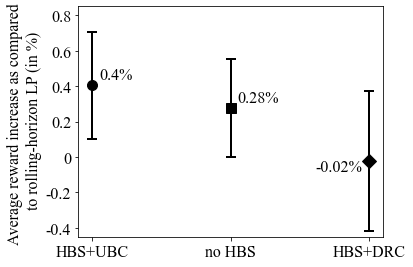

In [141]:
configs = ["p_nn_xy_lp", "p_nn_xy_lp_nohistory", "p_nn_xy_lp_default_normalization", "lp_only"]
labels = ["HBS+UBC", "no HBS", "HBS+DRC", "LP"]
markers = ["o", "s", "D", "x"]

#plot boxplots of rewards for different settings
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
#change boxplot color
plt.rcParams["boxplot.boxprops.color"] = "black"
plt.rcParams["boxplot.whiskerprops.color"] = "black"
plt.rcParams["boxplot.capprops.color"] = "black"
plt.rcParams["boxplot.flierprops.color"] = "black"
plt.rcParams["boxplot.medianprops.linewidth"] = 1.0
plt.rcParams["boxplot.medianprops.color"] = "black"

plt.rcParams["boxplot.meanline"] = False
plt.rcParams["boxplot.meanprops.color"] = "black"
plt.rcParams["boxplot.meanprops.linewidth"] = 2.0

#create batches of rewards of specified size
batch_size =250
reward_batches_mean = {i: [np.mean((rewards[i][j:j+batch_size]+1)/2) for j in range(0, data_size, batch_size)] for i in configs}
reward_batches_std = {i: np.std(reward_batches_mean[i]) for i in configs}

#get percentage improvement of each setting compared to lp_only for each batch
improvement = {i: [(reward_batches_mean[i][j] - reward_batches_mean["lp_only"][j])/reward_batches_mean["lp_only"][j] for j in range(len(reward_batches_mean[i]))] for i in configs}
print(improvement)
improvement_mean = {i: np.mean(improvement[i]) for i in configs}
improvement_confidence = {i: st.t.interval(0.95, len(improvement[i])-1, loc=np.mean(improvement[i]), scale=st.sem(improvement[i])) for i in configs}
print(improvement_confidence)
improvement_std = {i: np.std(improvement[i]) for i in configs}

#plot improvement mean and confidence as error bars in both directions for each configuration except for lp_only
for i in range(len(configs)-1):
    plt.errorbar(i, improvement_mean[configs[i]], yerr=(improvement_confidence[configs[i]][1]-improvement_mean[configs[i]]), fmt=markers[i], markersize=10, label=f"{labels[i]}", color="black", barsabove=True, capsize=5, capthick=2, elinewidth=2, ecolor="black")
    
    #plt.errorbar(i, improvement_mean[configs[i]], yerr=improvement_std[configs[i]]/2, fmt=markers[i], markersize=10, label=f"{labels[i]}", color="black", barsabove=True, capsize=5, capthick=2, elinewidth=2, ecolor="black")
    if i<2: 
        plt.text(i+0.05, improvement_mean[configs[i]]+0.0001, f"{np.round(improvement_mean[configs[i]]*100,2)}%", ha='left', va='bottom')
    else:
        plt.text(i-0.05, improvement_mean[configs[i]]+0.0001, f"{np.round(improvement_mean[configs[i]]*100,2)}%", ha='right', va='top')




# #for each configuration, plot the reward_batches_mean mean and the reward_batches_std as error bars in both directions
# for i in range(len(configs)):
#     plt.errorbar(configs[i], np.mean(reward_batches_mean[configs[i]]), yerr=reward_batches_std[configs[i]]/2, fmt=markers[i], markersize=10, label=f"{labels[i]}", color="black", barsabove=True, capsize=5, capthick=2, elinewidth=2, ecolor="black")
#     #plt.text(i, np.mean((rewards[configs[i]]+1)/2)+0.0001, f"{np.round(np.mean((rewards[configs[i]]+1)/2)*100,2)}%", ha='left', va='bottom')
#     if i < 2:
#         plt.text(i+0.05, np.mean(reward_batches_mean[configs[i]])+0.0015, f"{np.round(np.mean(reward_batches_mean[configs[i]])*100,2)}%", ha='left', va='bottom')
#     else:
#         plt.text(i-0.05, np.mean(reward_batches_mean[configs[i]])-0.0015, f"{np.round(np.mean(reward_batches_mean[configs[i]])*100,2)}%", ha='right', va='top')



# for i in range(len(configs)):
#     plt.plot(i, np.mean((rewards[configs[i]]+1)/2), marker=markers[i], markersize=10, label=f"{labels[i]}: {np.round(np.mean(rewards[configs[i]])*100,2)}%", color="black")
#     if i < 2:
#         plt.text(i, np.mean((rewards[configs[i]]+1)/2)+0.0001, f"{np.round(np.mean((rewards[configs[i]]+1)/2)*100,2)}%", ha='left', va='bottom')
#     else:
#         plt.text(i, np.mean((rewards[configs[i]]+1)/2)+0.0001, f"{np.round(np.mean((rewards[configs[i]]+1)/2)*100,2)}%", ha='right', va='bottom')
plt.ylabel("Average reward increase as compared \n to rolling-horizon LP (in %)")
plt.xticks(range(len(configs)-1), labels[:-1])
#plt.yticks(np.arange(0.94,0.945,0.001), ["94", "94.1", "94.2", "94.3", "94.4", "94.5"])
#change range of y-axis
plt.ylim(-0.0045,0.0085)
plt.yticks(np.arange(-0.004,0.0085,0.002), ["-0.4", "-0.2", "0", "0.2", "0.4", "0.6", "0.8"])
#plt.yticks(np.arange(0.935,0.955,0.005), ["93.5", "94", "94.5", "95"])
#all text labels should be inside of outer box

plt.tight_layout()
#plt.yticks([0.88, 0.882, 0.884, 0.886, 0.888, 0.89], ["88", "88.2", "88.4", "88.6", "88.8", "89"])
#plt.legend()
plt.savefig(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\reward_comparison_shaping.pdf")
plt.show()


[   0  499  999 1499 1999 2499 2999 3499 3999 4499]
[45.062789585683575, 65.4967870248291, 74.04078697617314, 65.70911488202896, 62.40282136097203, 58.66040016955762, 58.16078999708961, 70.80387242642873, 70.37694621742442, 58.89452010268286]
[61.218782551777885, 92.27195196547993, 93.89822850442036, 90.1241667860771, 87.4180474133207, 83.34617389841272, 74.18160417845465, 98.50793984210857, 94.39335679223666, 80.1927030685321]
Mean discounted reward for PPO: 63.949804192900565
Mean discounted reward for APO: 88.7711070996989
Mean discounted reward for LP: 85.79317583621676


C:\Users\ga84cib\AppData\Local\Temp/ipykernel_9324/2486290006.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  discounted_rewards_ppo = [np.sum(discount_factor**(jj-j) * rewards_ppo[jj] for jj in range(j, data_size)) for j in reward_indices]
C:\Users\ga84cib\AppData\Local\Temp/ipykernel_9324/2486290006.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  discounted_rewards_apo = [np.sum(discount_factor**(jj-j) * rewards_apo[jj] for jj in range(j, data_size)) for j in reward_indices]
C:\Users\ga84cib\AppData\Local\Temp/ipykernel_9324/2486290006.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

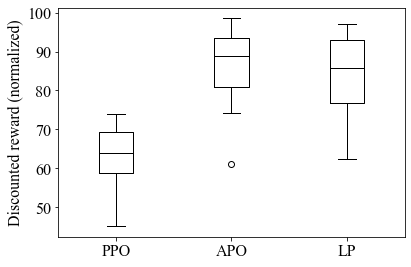

In [21]:
rewards_ppo = rewards["p_nn_xy_lp_ppo"]
rewards_apo = rewards["p_nn_xy_lp"]

#get 20 equidistant points in reward dataset and calculate the discounted reward for each setting
reward_indices = np.linspace(0, data_size-501, 10, dtype=int)
print(reward_indices)
discounted_rewards_ppo = [np.sum(discount_factor**(jj-j) * rewards_ppo[jj] for jj in range(j, data_size)) for j in reward_indices]
discounted_rewards_apo = [np.sum(discount_factor**(jj-j) * rewards_apo[jj] for jj in range(j, data_size)) for j in reward_indices]
discounted_rewards_lp = [np.sum(discount_factor**(jj-j) * rewards["lp_only"][jj] for jj in range(j, data_size)) for j in reward_indices]

#mean discounted reward for each setting
print(discounted_rewards_ppo)
print(discounted_rewards_apo)
print(f"Mean discounted reward for PPO: {np.median(discounted_rewards_ppo)}")
print(f"Mean discounted reward for APO: {np.median(discounted_rewards_apo)}")
print(f"Mean discounted reward for LP: {np.median(discounted_rewards_lp)}")

#plot boxplot of discounted rewards for each setting
import matplotlib.pyplot as plt
#change plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
#change boxplot color
plt.rcParams["boxplot.boxprops.color"] = "black"
plt.rcParams["boxplot.whiskerprops.color"] = "black"
plt.rcParams["boxplot.capprops.color"] = "black"
plt.rcParams["boxplot.flierprops.color"] = "black"
plt.rcParams["boxplot.medianprops.linewidth"] = 1.0
plt.rcParams["boxplot.medianprops.color"] = "black"

plt.rcParams["boxplot.meanline"] = False
plt.rcParams["boxplot.meanprops.color"] = "black"
plt.rcParams["boxplot.meanprops.linewidth"] = 2.0




plt.boxplot([discounted_rewards_ppo, discounted_rewards_apo, discounted_rewards_lp])
plt.xticks([1,2,3], ["PPO", "APO", "LP"])
plt.ylabel("Discounted reward (normalized)")
plt.tight_layout()
plt.savefig(f"C:\\Users\\ga84cib\\Documents\\gitlab\\ameliorating_inventory_drl\\problem_configurations\\{problem_id}\\discounted_rewards.pdf")
plt.show()

#save plot to pdf

